In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.0 MB/s eta 0:00:00


In [133]:
## Importing libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import optuna
import os
import joblib
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
## Loading in Data
sale = pd.read_csv('/content/sale_modeling.csv')
skubal = pd.read_csv('/content/skubal_modeling.csv')

# Introduction

Now that all the necessary steps before modeling are done, I can start actually modeling. To do so, I need to hyperparameter tune, evaluate, and select the best models. I also will be doing this separately for each pitcher. At the end of this, while I don't think I will get perfect results, I would like to see if there is a difference in prediction accuracy with these pitchers.

Note: In my experience with RNNs, I have never used PyTorch. This project is going to help me learn PyTorch along with learn actually about what the models produce.

## Chris Sale


First thing's first, I need to split the data into training and testing. I will use 80% of the sequences to train and 20% of the data to test.

In [5]:
def create_sequences_sale(data, features, sequence_length=3): ## Need different functions for Sale and Skubal because they have different arsenals
    sequences = []
    targets = []

    for seq_id, group in data.groupby('seq_id'):
        pitch_features = group[features].values
        pitch_types = group[['pitch_type_CH', 'pitch_type_FF', 'pitch_type_SI', 'pitch_type_SL']].values

        if len(pitch_features) >= sequence_length + 1:
            for i in range(len(pitch_features) - sequence_length):
                sequences.append(pitch_features[i:i + sequence_length])
                targets.append(pitch_types[i + sequence_length])

    return np.array(sequences), np.array(targets)


## Explanatory pitch features
features = ['release_speed', 'release_pos_x', 'release_pos_y', 'release_pos_z',
            'release_spin_rate', 'spin_axis', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z',
            'sz_top', 'sz_bot', 'balls', 'strikes', 'outs_when_up', 'inning',
            'inning_topbot_Bot', 'inning_topbot_Top', 'stand_L', 'stand_R', 'p_throws_L']

X, y = create_sequences_sale(sale, features)

def train_test_split_sequences(data, features, test_size=0.2):

    unique_seq_ids = data['seq_id'].unique()
    train_ids, test_ids = train_test_split(unique_seq_ids, test_size=test_size, random_state=42)

    train_df = data[data['seq_id'].isin(train_ids)]
    test_df = data[data['seq_id'].isin(test_ids)]

    X_train, y_train = create_sequences_sale(train_df, features)
    X_test, y_test = create_sequences_sale(test_df, features)

    return X_train, y_train, X_test, y_test

## Creating actual splits
X_train_sale, y_train_sale, X_test_sale, y_test_sale = train_test_split_sequences(sale, features)

### Hyperparameter Tuning using Optuna

This is my first time using Optuna in cahoots with Pytorch RNN building, so I am still learning.

For my model, I am choosing to use Gated Recurrent Units (GRU) instead of LSTM because the sequences are short and simple (3 timesteps). LSTMs work better when the sequences are longer. Also, I don't have the computational power to run a good enough LSTM.

In [126]:
BATCHSIZE = 64
EPOCHS = 10
DIR = os.getcwd()

## Creating the GRU -- Need dropouts because with such small data and the fact that there aren't many options for output, overfitting is a risk
def create_gru_model(input_size, hidden_size, num_layers, output_size, dropout_rate):
    gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
    dropout = nn.Dropout(dropout_rate)
    linear = nn.Linear(hidden_size, output_size)

    model = nn.Sequential(
        gru,
        Lambda(lambda x: x[0]), ## Extracting output layer
        dropout,
        linear,
        nn.Dropout(dropout_rate)
    )
    return model

## Lambda layer for extracting the output
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

## For Hyperparameter Tuning
def objective(trial):

    hidden_size = trial.suggest_int("hidden_size", 32, 128)
    learning_rate = trial.suggest_float("learning_rate", 5e-5, 1e-3, log=True)
    num_layers = trial.suggest_categorical("num_layers", [1, 2, 3])
    dropout = trial.suggest_float("dropout", 0.1, 0.5)

    ## Create GRU model using above function
    model = create_gru_model(input_size=21, hidden_size=hidden_size, num_layers=num_layers, output_size=4, dropout_rate= dropout)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    ## Converting data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_sale, dtype=torch.float32)

    # Convert one-hot encoded target to class indices
    y_train_sale_classes = np.argmax(y_train_sale, axis=1)
    y_train_tensor = torch.tensor(y_train_sale_classes, dtype=torch.long)

    # Training over epochs
    for epoch in range(EPOCHS):
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        outputs = outputs[:, -1, :]
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    # Evaluate the model
    with torch.no_grad():
        outputs = model(X_train_tensor)
        outputs = outputs[:, -1, :]
        loss = criterion(outputs, y_train_tensor)

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == y_train_tensor).sum().item()
        total = y_train_tensor.size(0)
        accuracy = correct / total

    return loss.item(), accuracy  # Return both loss and accuracy

# Create and run the Optuna study
study = optuna.create_study(directions=["minimize", "maximize"]) ## For loss and accuracy
study.optimize(objective, n_trials=80, n_jobs=1)


# Get the best trial and hyperparameters
best_trials = study.best_trials

# Print the best trials
for trial in best_trials:
    print("Trial params:", trial.params)
    print("Trial Accuracy:", trial.values[1])
    print("Trial Loss:", trial.values[0])

study_filename = "optuna_study_sale.pkl"
joblib.dump(study, study_filename)

[I 2025-03-25 20:09:56,148] A new study created in memory with name: no-name-54c2d908-8e25-4556-9f5d-3d72e0ca30db
[I 2025-03-25 20:09:56,350] Trial 0 finished with values: [1.350733995437622, 0.37116564417177916] and parameters: {'hidden_size': 79, 'learning_rate': 5.907158038440355e-05, 'num_layers': 3, 'dropout': 0.20217129253951638}.
[I 2025-03-25 20:09:56,423] Trial 1 finished with values: [1.2792413234710693, 0.48466257668711654] and parameters: {'hidden_size': 83, 'learning_rate': 0.0009102727954844167, 'num_layers': 1, 'dropout': 0.19758609048658846}.
[I 2025-03-25 20:09:56,711] Trial 2 finished with values: [1.2947088479995728, 0.44171779141104295] and parameters: {'hidden_size': 101, 'learning_rate': 0.0004831071558914533, 'num_layers': 3, 'dropout': 0.27309959686721413}.
[I 2025-03-25 20:09:57,061] Trial 3 finished with values: [1.3581626415252686, 0.30368098159509205] and parameters: {'hidden_size': 123, 'learning_rate': 9.989464381968638e-05, 'num_layers': 3, 'dropout': 0.3

Trial params: {'hidden_size': 110, 'learning_rate': 0.0008505924493379839, 'num_layers': 2, 'dropout': 0.11898358190583852}
Trial Accuracy: 0.5061349693251533
Trial Loss: 1.2200591564178467


['optuna_study_sale.pkl']

Based on Optuna's hyperparameter tuning here, we have a few best trials. I am going to use some of Optuna's visualization techniques to compare trials.

In [152]:
study_sale = joblib.load("optuna_study_sale.pkl")
print("\033[1m\033[94mChris Sale Hyperparameter Tuning with Optuna, all trials.\033[0m")
optuna.visualization.plot_pareto_front(study_sale)

Chris Sale Hyperparameter Tuning with Optuna, all trials.


This plot shows the tradeoff of each trial between loss (objective 0) and accuracy (objective 1). The plot highlights the top left corner as the best trial, as it has the best tradeoff between loss and accuracy. Hovering over it, you can see that it was trial number 49, and it has a loss of 0.34 and accuracy of 0.89. This is much better than expected, leading me to believe there may be some overfitting.

I am going to retrain it and run it against the testing data to truly see if it predicts that well, or if it is in fact overfit.

In [128]:
# Trial params: {'hidden_size': 110, 'learning_rate': 0.0008505924493379839, 'num_layers': 2, 'dropout': 0.11898358190583852}


## Selected Hyperparameters
hidden_size = 110
learning_rate =  0.0008505924493379839
num_layers = 2
dropout = 0.11898358190583852

## Create the model based on the function above
model = create_gru_model(
    input_size=21,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=4,
    dropout_rate=dropout,
)

# Define Loss and Optimizer, adding a weight decay, an L2 Regularization, to help with overfitting
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [129]:
## Creating PyTorch sensors for the training and testing
X_train_tensor_sale = torch.tensor(X_train_sale, dtype=torch.float32)
X_test_tensor_sale = torch.tensor(X_test_sale, dtype=torch.float32)

# Convert one-hot encoded target to class indices
y_train_sale_classes = np.argmax(y_train_sale, axis=1)
y_train_tensor_sale = torch.tensor(y_train_sale_classes, dtype=torch.long)
y_test_sale_classes = np.argmax(y_test_sale, axis=1)
y_test_tensor_sale = torch.tensor(y_test_sale_classes, dtype=torch.long)

# Create TensorDataset and DataLoader
train_dataset_sale = TensorDataset(X_train_tensor_sale, y_train_tensor_sale)
train_loader_sale = DataLoader(train_dataset_sale, batch_size= BATCHSIZE, shuffle=True)

test_dataset_sale = TensorDataset(X_test_tensor_sale, y_test_tensor_sale)
test_loader_sale = DataLoader(test_dataset_sale, batch_size=BATCHSIZE, shuffle=False)

In [130]:
## Training model on selected epochs above
for epoch in range(EPOCHS):
    model.train()
    for batch_X, batch_y in train_loader_sale:
        optimizer.zero_grad()
        outputs = model(batch_X)
        outputs = outputs[:, -1, :]
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

In [131]:
## Evaluating the model
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor_sale)
    outputs = outputs[:, -1, :]
    loss = criterion(outputs, y_test_tensor_sale)

    _, predicted = torch.max(outputs, 1)
    correct = (predicted == y_test_tensor_sale).sum().item()
    total = y_test_tensor_sale.size(0)
    accuracy = correct / total

print(f"Test Loss: {loss.item()}, Test Accuracy: {accuracy}")

Test Loss: 1.2198703289031982, Test Accuracy: 0.4024390243902439


This required a lot of playing around. Whether it be changing epochs, changing batch size, or changing the parameters, I tried many different combinations. Here were some of the trials I ran that had the best outputs.


####**Trial 1**

BATCHSIZE = 64
EPOCHS = 15

Trial params: {'hidden_size': 120, 'learning_rate': 0.009322631193715757, 'num_layers': 2, 'dropout': 0.17916460429601871}

Test Loss: 1.4174426794052124, Test Accuracy: 0.5


####**Trial 2**

BATCHSIZE = 64
EPOCHS = 12

Trial params: {'hidden_size': 109, 'learning_rate': 0.006288788804388749, 'num_layers': 2, 'dropout': 0.14464301771388333}

Test Loss: 1.1556916236877441, Test Accuracy: 0.5

####**Trial 3**

BATCHSIZE = 64
EPOCHS = 10

Trial params: {'hidden_size': 86, 'learning_rate': 0.009501936825399479, 'num_layers': 2, 'dropout': 0.13467693235734673}

Test Loss: 1.1827853918075562, Test Accuracy: 0.5121951219512195

####**Trial 4**

BATCHSIZE = 32
EPOCHS = 10

Trial params: {'hidden_size': 59, 'learning_rate': 0.008258319100444264, 'num_layers': 1, 'dropout': 0.1136566167713085}

Test Loss: 1.2344555854797363, Test Accuracy: 0.5

\
###**Conclusion**

We see that none of these trials are that great. I knew going in that the accuracy of this model was not going to be great. What I am looking for is the best balance between test loss and test accuracy. Trial 3 seems to be the best for me.

\
So, my final model for Chris Sale is:

Hidden Size: 86 \
Learning Rate: 0.009501936825399479 \
Number of Layers: 2 \
Dropout Rate: 0.13467693235734673

\
I am going to fit this as my final model and then look at some of the common mistakes of this model.

In [132]:
hidden_size = 86
learning_rate =  0.009501936825399479
num_layers = 2
dropout = 0.13467693235734673
BATCHSIZE = 64
EPOCHS = 10

## Fitting final model
sale_model_final = create_gru_model(
    input_size=21,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=4,
    dropout_rate=dropout,
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

## Training
for epoch in range(EPOCHS):
    sale_model_final.train()
    for batch_X, batch_y in train_loader_sale:
        optimizer.zero_grad()
        outputs = model(batch_X)
        outputs = outputs[:, -1, :]
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

## Making Predictions
sale_model_final.eval()
with torch.no_grad():
    outputs = model(X_test_tensor_sale)
    outputs = outputs[:, -1, :]
    _, predicted = torch.max(outputs, 1)

predicted_sale = predicted.cpu().numpy()
true_labels_sale = y_test_tensor_sale.cpu().numpy()

Let's see some visuals as to where this model goes wrong.

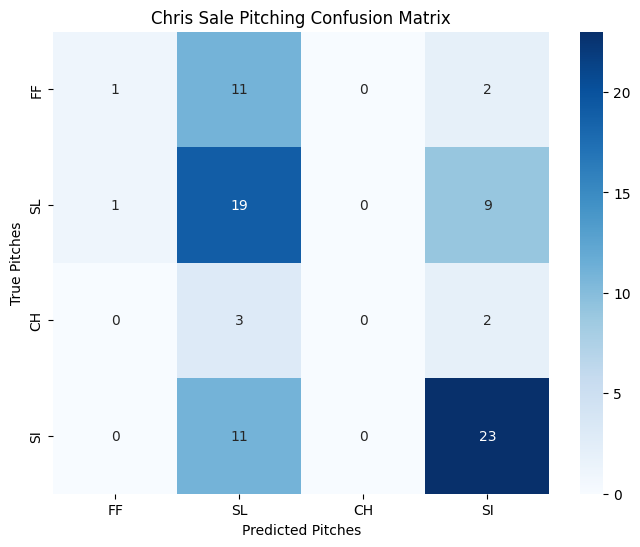

In [140]:
## Confusion Matrix
pitch_labels = ["FF", "SL", "CH", "SI"]

true_pitch_labels_sale = [pitch_labels[label] for label in true_labels_sale]
predicted_pitch_labels_sale = [pitch_labels[label] for label in predicted_sale]

cm = confusion_matrix(true_pitch_labels_sale, predicted_pitch_labels_sale, labels=pitch_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=pitch_labels, yticklabels=pitch_labels)
plt.xlabel('Predicted Pitches')
plt.ylabel('True Pitches')
plt.title('Chris Sale Pitching Confusion Matrix')
plt.show();

We see that the most common mistake made by the model is confusing Sinker and Slider. We see 11 pitches that were predicted to be sliders that were actually sinkers, and 9 that were predicted to be sinkers that were actually sliders. The second most common confusion by this model is Slider and Fastball. 11 pitches that were predicted slider were actually fastballs. What is quite interesting about this is that there is only 1 pitch that is the inverse.

The pitch that is most common correctly predicted is sinker, as 23 predicted sinkers were actually sinkers. The second most common correctly predicted is slider, as 19 pitches were classified correctly in this category.

Looking back at the pitch usage in the EDA, we see that Chris Sale uses his slider the most. So, it makes sense that most of the pitches were predicted to be sliders. However, he uses his four seam fastball the second most and his sinker the least, which is not reflected above. Based on pitch usage, I would think more would be predicted fastball, yet only 2 pitches were predicted so. On the other hand, sinkers were the least used pitch in 2024 for Chris Sale, yet it is the second most common prediction.

Let's look at the first 5 sequences to see more.

In [150]:
first_5_sequences_sale = X_test_tensor_sale[:5]
first_5_predictions_sale = predicted_sale[:5]
first_5_true_labels_sale = true_labels_sale[:5]

# Convert numerical labels to pitch names
predicted_pitches_sale = [pitch_labels[label] for label in first_5_predictions_sale]
true_pitches_sale = [pitch_labels[label] for label in first_5_true_labels_sale]

# Extract the first three pitches from each sequence (assuming 21 features)
first_3_pitches = []
for sequence in first_5_sequences_sale:
    sequence_pitches = []
    for i in range(3):
        pitch_number = int(sequence[i, 0].item())
        sequence_pitches.append(pitch_labels[pitch_number])
    first_3_pitches.append(sequence_pitches)

# Create the DataFrame
data_sale = {
    "Sequence Number": range(5),
    "Pitch 1": [pitches[0] for pitches in first_3_pitches],
    "Pitch 2": [pitches[1] for pitches in first_3_pitches],
    "Pitch 3": [pitches[2] for pitches in first_3_pitches],
    "Predicted Pitch 4": predicted_pitches_sale,
    "Actual Pitch 4": true_pitches_sale,
}

df_sale = pd.DataFrame(data_sale)
print("\033[1m\033[94mChris Sale's First 5 Pitch Sequences in 2024.\033[0m")
df_sale


Chris Sale's First 5 Pitch Sequences in 2024.


,Sequence Number,Pitch 1,Pitch 2,Pitch 3,Predicted Pitch 4,Actual Pitch 4
0,0,FF,FF,SI,SL,SL
1,1,SI,FF,FF,SL,SL
2,2,SL,FF,SI,SI,SI
3,3,FF,SI,SI,SL,SI
4,4,FF,FF,SL,SL,SI


It is cool just to look at the first 5 sequences to see if they were correct and what pitches came before. The first 3 sequences were predicted correctly. However, the final 2 were predicted to be sliders that were actually sinkers. Based on Chris Sale's Pitch Usage, this makes sense.

Before we can jump to any mega-final conclusions, it is time to model Tarik Skubal!

## Tarik Skubal

I am going to follow the exact same methods as I did for Chris Sale.

In [154]:
## Tarik Skubal Sequences
def create_sequences_skubal(data, features, sequence_length=3):
    sequences = []
    targets = []

    for seq_id, group in data.groupby('seq_id'):
        pitch_features = group[features].values
        pitch_types = group[['pitch_type_CH', 'pitch_type_FF', 'pitch_type_KC','pitch_type_SI', 'pitch_type_SL']].values

        if len(pitch_features) >= sequence_length + 1:
            for i in range(len(pitch_features) - sequence_length):
                sequences.append(pitch_features[i:i + sequence_length])
                targets.append(pitch_types[i + sequence_length])

    return np.array(sequences), np.array(targets)


## Explanatory pitch features
features = ['release_speed', 'release_pos_x', 'release_pos_y', 'release_pos_z',
            'release_spin_rate', 'spin_axis', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z',
            'sz_top', 'sz_bot', 'balls', 'strikes', 'outs_when_up', 'inning',
            'inning_topbot_Bot', 'inning_topbot_Top', 'stand_L', 'stand_R', 'p_throws_L']

X, y = create_sequences_skubal(skubal, features)

def train_test_split_sequences_skubal(data, features, test_size=0.2):

    unique_seq_ids = data['seq_id'].unique()
    train_ids, test_ids = train_test_split(unique_seq_ids, test_size=test_size, random_state=42)

    train_df = data[data['seq_id'].isin(train_ids)]
    test_df = data[data['seq_id'].isin(test_ids)]

    X_train, y_train = create_sequences_skubal(train_df, features)
    X_test, y_test = create_sequences_skubal(test_df, features)

    return X_train, y_train, X_test, y_test

## Creating actual splits
X_train_skubal, y_train_skubal, X_test_skubal, y_test_skubal = train_test_split_sequences_skubal(skubal, features)

Now that we have the sequences, it's time for hyperparameter tuning.

In [156]:
BATCHSIZE = 64
EPOCHS = 10
DIR = os.getcwd()

## Can use the same create_gru_model() and Lambda Class as above, since it does not change for each pitcher.

## For Hyperparameter Tuning
def objective_skubal(trial):

    hidden_size = trial.suggest_int("hidden_size", 32, 128)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    num_layers = trial.suggest_categorical("num_layers", [1, 2, 3])
    dropout = trial.suggest_float("dropout", 0.1, 0.5)

    ## Create GRU model using above function
    model = create_gru_model(input_size=21, hidden_size=hidden_size, num_layers=num_layers, output_size=5, dropout_rate= dropout)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    ## Converting data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_skubal, dtype=torch.float32)

    # Convert one-hot encoded target to class indices
    y_train_skubal_classes = np.argmax(y_train_skubal, axis=1)
    y_train_tensor = torch.tensor(y_train_skubal_classes, dtype=torch.long)

    # Training over epochs
    for epoch in range(EPOCHS):
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        outputs = outputs[:, -1, :]
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    # Evaluate the model
    with torch.no_grad():
        outputs = model(X_train_tensor)
        outputs = outputs[:, -1, :]
        loss = criterion(outputs, y_train_tensor)

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == y_train_tensor).sum().item()
        total = y_train_tensor.size(0)
        accuracy = correct / total

    return loss.item(), accuracy  # Return both loss and accuracy

# Create and run the Optuna study
study_skubal = optuna.create_study(directions=["minimize", "maximize"])
study_skubal.optimize(objective_skubal, n_trials=80, n_jobs=1)


# Get the best trial and hyperparameters
best_trials_skubal = study_skubal.best_trials

# Print the best trials
for trial in best_trials_skubal:
    print("Trial params:", trial.params)
    print("Trial Accuracy:", trial.values[1])
    print("Trial Loss:", trial.values[0])

study_filename_skubal = "optuna_study_skubal.pkl"
joblib.dump(study_skubal, study_filename_skubal)

[I 2025-03-25 20:58:16,072] A new study created in memory with name: no-name-941f97a1-b40f-4aeb-953e-b42c7fbd8016
[I 2025-03-25 20:58:16,384] Trial 0 finished with values: [1.3910924196243286, 0.39097744360902253] and parameters: {'hidden_size': 73, 'learning_rate': 0.0013451550916233597, 'num_layers': 3, 'dropout': 0.1357425549460586}.
[I 2025-03-25 20:58:16,531] Trial 1 finished with values: [1.4650449752807617, 0.3383458646616541] and parameters: {'hidden_size': 95, 'learning_rate': 0.0017488372355886743, 'num_layers': 1, 'dropout': 0.49543945559076263}.
[I 2025-03-25 20:58:16,789] Trial 2 finished with values: [1.2192535400390625, 0.48872180451127817] and parameters: {'hidden_size': 89, 'learning_rate': 0.009512591120465786, 'num_layers': 2, 'dropout': 0.40698195049827934}.
[I 2025-03-25 20:58:17,068] Trial 3 finished with values: [1.5821863412857056, 0.2781954887218045] and parameters: {'hidden_size': 53, 'learning_rate': 0.0002617374992355524, 'num_layers': 2, 'dropout': 0.361038

Trial params: {'hidden_size': 102, 'learning_rate': 0.009416482994198196, 'num_layers': 2, 'dropout': 0.12116636307630856}
Trial Accuracy: 0.6015037593984962
Trial Loss: 0.974607527256012
Trial params: {'hidden_size': 89, 'learning_rate': 0.009512591120465786, 'num_layers': 3, 'dropout': 0.1549163089512875}
Trial Accuracy: 0.6090225563909775
Trial Loss: 0.9896976947784424


['optuna_study_skubal.pkl']